# Multiclass GDA (LDA & QDA) with NumPy

We assume a dataset:

* `X`: shape `(n_samples, n_features)`
* `y`: shape `(n_samples,)`, with class labels in `{0, 1, ..., K-1}`

## Required Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Compute Class Priors and Mean

* **Class priors**:

  $$
  \phi_k = \frac{n_k}{n}, \quad \text{where } n_k = \sum_{i=1}^n \mathbb{1}\{y_i = k\}
  $$

* **Class means**:

  $$
  \mu_k = \frac{1}{n_k} \sum_{i: y_i = k} x_i
  $$

In [2]:
def compute_class_priors(y, K):
    n = len(y)
    priors = np.array([np.sum(y == k) for k in range(K)]) / n
    return priors

def compute_class_means(X, y, K):
    d = X.shape[1]
    means = np.zeros((K, d))
    for k in range(K):
        X_k = X[y == k]
        means[k] = np.mean(X_k, axis=0)
    return means

## Linear Discriminant Analysis (LDA)

* **Shared covariance matrix**:

  $$
  \Sigma = \frac{1}{n} \sum_{k=0}^{K-1} \sum_{i: y_i = k} (x_i - \mu_k)(x_i - \mu_k)^\top
  $$


In [3]:
def lda_fit(X, y):
    n, d = X.shape
    classes = np.unique(y)
    K = len(classes)

    priors = compute_class_priors(y, K)
    means = compute_class_means(X, y, K)

    # Shared covariance matrix
    Sigma = np.zeros((d, d))
    for k in range(K):
        X_k = X[y == k]
        centered = X_k - means[k]
        Sigma += centered.T @ centered
    Sigma /= n 

    return priors, means, Sigma

### LDA Prediction

Each class has a discriminant function:

$$
g_k(x) = x^\top \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^\top \Sigma^{-1} \mu_k + \log \phi_k
$$

Predict:

$$
\boxed{h(x) = \arg\max_k \, g_k(x)}
$$

In [4]:
def lda_predict(X, priors, means, Sigma):
    Sigma_inv = np.linalg.inv(Sigma)
    scores = []
    for k in range(len(priors)):
        w_k = Sigma_inv @ means[k]
        b_k = -0.5 * means[k].T @ Sigma_inv @ means[k] + np.log(priors[k])
        g_k = X @ w_k + b_k
        scores.append(g_k)
    scores = np.array(scores) 
    return np.argmax(scores, axis=0)

## Quadratic Discriminant Analysis (QDA)

* **Class-specific covariance**:

  $$
  \Sigma_k = \frac{1}{n_k} \sum_{i: y_i = k} (x_i - \mu_k)(x_i - \mu_k)^\top
  $$

In [5]:
def qda_fit(X, y):
    n, d = X.shape
    classes = np.unique(y)
    K = len(classes)

    priors = compute_class_priors(y, K)
    means = compute_class_means(X, y, K)

    covariances = []
    for k in range(K):
        X_k = X[y == k]
        centered = X_k - means[k]
        cov_k = (centered.T @ centered) / len(X_k)
        covariances.append(cov_k)
    
    return priors, means, covariances

### QDA Prediction
Each class has a quadratic discriminant:

$$
g_k(x) = -\frac{1}{2} \log |\Sigma_k| - \frac{1}{2}(x - \mu_k)^\top \Sigma_k^{-1}(x - \mu_k) + \log \phi_k
$$

Predict:

$$
\boxed{h(x) = \arg\max_k \, g_k(x)}
$$

In [6]:
def qda_predict(X, priors, means, covariances):
    n = X.shape[0]
    K = len(priors)
    scores = np.zeros((K, n))

    for k in range(K):
        mean = means[k]
        cov = covariances[k]
        cov_inv = np.linalg.inv(cov)
        diff = X - mean
        term1 = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        term2 = -0.5 * np.log(np.linalg.det(cov) + 1e-10)  # +epsilon for stability
        term3 = np.log(priors[k])
        scores[k] = term1 + term2 + term3

    return np.argmax(scores, axis=0)

## Plotting Function for LDA and QDA

In [7]:
def plot_decision_boundary(X, y, predict_func, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02 

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = predict_func(grid)
    Z = Z.reshape(xx.shape)

    classes = np.unique(y)
    num_classes = len(classes)
    
    cmap_light = ListedColormap(pyplot.get_cmap("tab10").colors[:num_classes])
    cmap_bold = pyplot.get_cmap("tab10").colors[:num_classes]

    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

    # Plot data points
    for i, color in zip(classes, cmap_bold):
        plt.scatter(X[y == i, 0], X[y == i, 1], c=[color], label=f"Class {i}", edgecolor='k')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()


## Example Usage

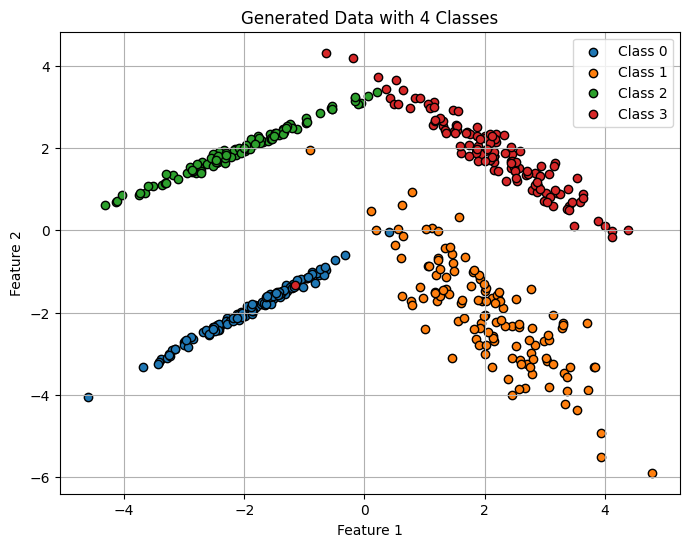

In [8]:
# Generate synthetic data with 4 classes
X, y = make_classification(
    n_samples=500,
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=42
)

# Plotting the generated data
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}', edgecolor='k')
plt.title("Generated Data with 4 Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


LDA accuracy: 0.97
QDA accuracy: 0.994


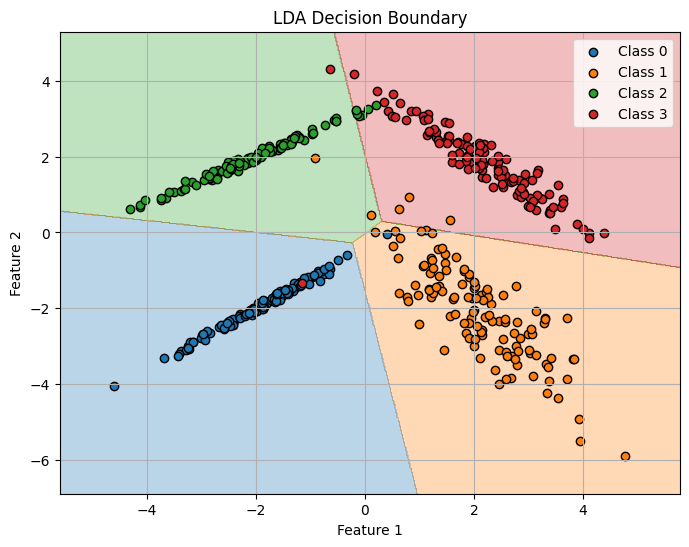

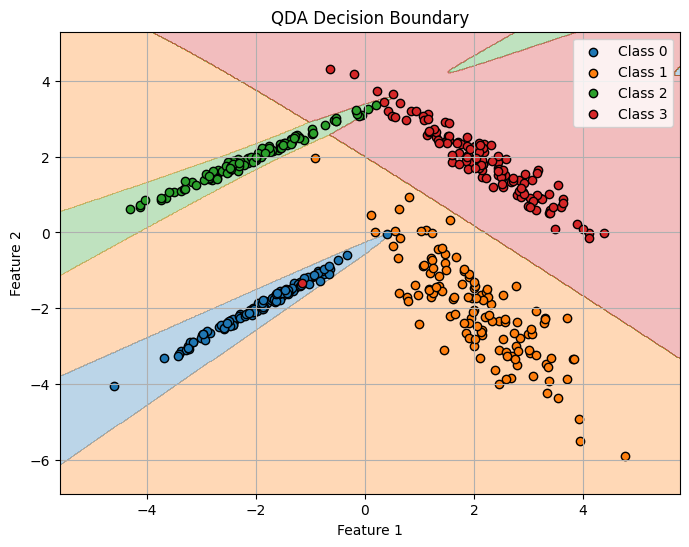

In [9]:

# Train LDA
priors_lda, means_lda, Sigma_lda = lda_fit(X, y)
y_pred_lda = lda_predict(X, priors_lda, means_lda, Sigma_lda)

# Train QDA
priors_qda, means_qda, covs_qda = qda_fit(X, y)
y_pred_qda = qda_predict(X, priors_qda, means_qda, covs_qda)

# Accuracy
print("LDA accuracy:", np.mean(y_pred_lda == y))
print("QDA accuracy:", np.mean(y_pred_qda == y))

# LDA prediction function wrapper
lda_predict_func = lambda X_grid: lda_predict(X_grid, priors_lda, means_lda, Sigma_lda)
plot_decision_boundary(X, y, lda_predict_func, title="LDA Decision Boundary")

# QDA prediction function wrapper
qda_predict_func = lambda X_grid: qda_predict(X_grid, priors_qda, means_qda, covs_qda)
plot_decision_boundary(X, y, qda_predict_func, title="QDA Decision Boundary")

##  Multiclass GDA (LDA & QDA) Class
Here we have combined all that we have discussed above in to a class. You can see the usage below

In [10]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    

from ek_ml_package.gaussian_discriminant_analysis import QDA, LDA

# Generate 2D data with 4 classes
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1,
                           n_classes=4, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate LDA
lda = LDA()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print(f"LDA Accuracy: {lda.accuracy(y_test, y_pred_lda):.4f}")

# Train and evaluate QDA
qda = QDA()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print(f"QDA Accuracy: {qda.accuracy(y_test, y_pred_qda):.4f}")

LDA Accuracy: 0.8067
QDA Accuracy: 0.9467
